In [1]:
# import các thư viện
import os
import numpy as np
import keras
from keras import layers
from tensorflow import data as tf_data
import matplotlib.pyplot as plt
import pandas as pd
from sklearn.model_selection import KFold, StratifiedKFold
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from PIL import Image

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
# mapping
labels = {
    "Others": 0,
    "Honda": 1,
    "Suzuki": 2,
    "Yamaha": 3,
    "VinFast": 4
}
reverse_map_labels = {
    0: "Others",
    1: "Honda",
    2: "Suzuki",
    3: "Yamaha",
    4: "VinFast"
}

In [4]:
path = "/content/drive/MyDrive/data/Public"
output_dir = 'MotocycleDataset.csv'
d1 = []
error = pd.read_csv('/content/invalid_image_paths(1).csv')
error_paths = error.iloc[:, 0].unique().tolist()

In [5]:
def read_path(path, out_put):
    data = []
    supported_formats = ['jpg', 'png', 'jpeg']

    for label in os.listdir(path):
        if label in labels:
            y = labels[label]
            i = 0
            new_path = os.path.join(path, label)
            if os.listdir(new_path):
                for img in os.listdir(new_path):
                    if i == 1001: break
                    if any(img.lower().endswith(fmt) for fmt in supported_formats):
                        path_img = os.path.join(label, img)
                        if path_img not in error_paths:
                          data.append((path_img, int(y)))
                          i += 1

    df = pd.DataFrame(data, columns=['ImageFullPath', 'CategoryID'])
    df.to_csv(out_put, sep=',', index=False)
    return df

In [ ]:
# # create file MotocycleDataset.csv
# def read_path1(path,out_put):
#   data = []
#   for label in os.listdir(path):
#     if label in labels:
#         y = labels[label]
#         new_path = os.path.join(path,label)
#         if os.listdir(new_path):
#           for img in os.listdir(new_path):
#                 type_img = img.split('.')[-1]

#                 if type_img == 'jfif' or type_img == 'webp' or type_img == 'jpe' or type_img == 'gif' or type_img == 'avif':
#                   path_img = os.path.join(label,img)
#                   d1.append(path_img)
#     #           if img.endswith('jpg') or img.endswith('jpeg') or img.endswith('png'):
#     #             path_img = os.path.join(label,img)
#     #             data.append((path_img,int(y)))
#     # df = pd.DataFrame(data,columns = ['ImageFullPath','CategoryID'])
#     # df.to_csv(out_put, sep=',',index=False)
#     # return d1

In [6]:
a = read_path(path,output_dir)
print(len(a))

5005


So sánh thời gian đọc ảnh của pil và cv2

In [7]:
path1 = "/content/drive/MyDrive/data/Public"
img_path = "/content/MotocycleDataset.csv"

In [8]:
import os
from sklearn.model_selection import train_test_split
from tensorflow.keras.utils import to_categorical
import cv2

In [9]:

from zipfile import ZipFile
import os
import cv2
import numpy as np
import matplotlib.pyplot as plt
import torch
from torch.utils.data import Dataset
from torchvision import datasets
from torchvision.transforms import ToTensor
import matplotlib.pyplot as plt
import pandas as pd
from PIL import Image
from torchvision import transforms
import torch.nn as nn
import torch.nn.functional as F
import torchvision
from sklearn.model_selection import train_test_split
from collections import Counter


In [10]:
data = pd.read_csv(img_path)
img = data['ImageFullPath']
label = data['CategoryID']
image = [os.path.join(path1, i) for i in img]

In [11]:
len(image)

5005

In [12]:
trainX, testX, trainY, testY = train_test_split(image, label, test_size=0.3, random_state=30)
train_label_count = Counter(trainY)
test_label_count = Counter(testY)

In [13]:
testX, valX, testY, valY = train_test_split(testX, testY, test_size=0.3, random_state=30)

In [14]:
train_label_count

Counter({3: 705, 1: 720, 2: 703, 0: 689, 4: 686})

In [15]:
test_label_count

Counter({4: 315, 1: 281, 3: 296, 2: 298, 0: 312})

In [16]:
print(len(trainX))
print(len(testX))
print(len(valX))

3503
1051
451


In [17]:
from PIL import Image, ImageFile
ImageFile.LOAD_TRUNCATED_IMAGES = True

In [18]:
class CustomDataset(Dataset):
    def __init__(self, img_paths, labels, num_classes, transform=None):
        self.img_paths = img_paths
        self.labels = np.array(labels)  # Convert labels to numpy array
        self.num_classes = num_classes
        self.transform = transform
    def __len__(self):
        return len(self.img_paths)

    def __getitem__(self, idx):
        img_path = self.img_paths[idx]
        label = self.labels[idx]  # Retrieve label as integer

        img_cv2 = cv2.imread(img_path)
        img_cv2_rgb = cv2.cvtColor(img_cv2, cv2.COLOR_BGR2RGB)
        img_pil_from_cv2 = Image.fromarray(img_cv2_rgb)

        if self.transform:
            img_pil_from_cv2 = self.transform(img_pil_from_cv2)

        # Convert image to float32
        img_pil_from_cv2 = img_pil_from_cv2.to(dtype=torch.float32)

        return img_pil_from_cv2,torch.tensor(label, dtype=torch.long)

In [19]:
data_transforms = {
    'train': transforms.Compose([
        transforms.Resize((224,224)),
        transforms.RandomHorizontalFlip(),
        #transforms.CenterCrop(160),
        # torchvision.transforms.ColorJitter(hue=.05, saturation=.05),
        transforms.ToTensor(),
        transforms.Normalize([0.5, 0.5, 0.5], [0.5, 0.5, 0.5])
    ]),
    'val': transforms.Compose([
        transforms.Resize((224,224)),
        #transforms.CenterCrop(160),
        transforms.ToTensor(),
        transforms.Normalize([0.5, 0.5, 0.5], [0.5, 0.5, 0.5])
    ]),
    'test': transforms.Compose([
        transforms.Resize((224,224)),
        #transforms.CenterCrop(160),
        transforms.ToTensor(),
        transforms.Normalize([0.5, 0.5, 0.5], [0.5, 0.5, 0.5])
    ]),
}

In [20]:
from torch.utils.data import Dataset, DataLoader

In [21]:
train_set = CustomDataset(trainX, trainY, num_classes = 5, transform=data_transforms['train'])
val_set = CustomDataset(valX,valY, num_classes = 5, transform=data_transforms['val'])
test_set = CustomDataset(testX,testY, num_classes = 5, transform=data_transforms['test'])

train_loader = DataLoader(train_set, batch_size=32, shuffle=True, pin_memory=True,num_workers=8)
val_loader = DataLoader(val_set, batch_size=32, shuffle=True, pin_memory=True,num_workers= 8)
test_loader = DataLoader(test_set, batch_size=32, shuffle=False,pin_memory=True,num_workers= 8)

/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:558: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(


In [ ]:
for i in test_loader:
  a,b = i
  print(a)
  print(b)
  break

tensor([[[[ 1.0000,  1.0000,  1.0000,  ...,  0.5373,  0.5922,  0.6549],
          [ 1.0000,  1.0000,  1.0000,  ...,  0.5294,  0.5451,  0.6235],
          [ 1.0000,  1.0000,  1.0000,  ...,  0.5294,  0.5294,  0.5608],
          ...,
          [-0.8510, -0.8118, -0.7647,  ..., -0.5843, -0.5216, -0.6314],
          [-0.8275, -0.8196, -0.8039,  ..., -0.6471, -0.4980, -0.6078],
          [-0.7961, -0.7804, -0.7725,  ..., -0.7412, -0.5294, -0.5373]],

         [[ 1.0000,  1.0000,  1.0000,  ...,  0.5451,  0.6157,  0.6784],
          [ 1.0000,  1.0000,  1.0000,  ...,  0.5451,  0.5686,  0.6471],
          [ 1.0000,  1.0000,  1.0000,  ...,  0.5451,  0.5529,  0.5843],
          ...,
          [-0.8431, -0.8039, -0.7569,  ..., -0.5765, -0.5137, -0.6235],
          [-0.8196, -0.8118, -0.7961,  ..., -0.6392, -0.4902, -0.6000],
          [-0.7882, -0.7725, -0.7647,  ..., -0.7333, -0.5216, -0.5294]],

         [[ 1.0000,  1.0000,  1.0000,  ...,  0.5922,  0.6549,  0.7176],
          [ 1.0000,  1.0000,  

In [27]:
print(len(train_loader.dataset))
print(len(test_loader.dataset))

3503
1051


In [28]:
def show_batch_images(images, labels, mean, std, max_images=16):
    plt.figure(figsize=(12, 12))
    for i in range(min(len(images), max_images)):
        image = images[i].numpy().transpose((1, 2, 0))  # Chuyển tensor từ dạng (C, H, W) sang (H, W, C)

        # Hoàn tác chuẩn hóa
        image = std * image + mean
        image = np.clip(image, 0, 1)  # Đảm bảo giá trị nằm trong khoảng [0, 1]

        plt.subplot(4, 4, i + 1)  # 4 hàng và 4 cột
        plt.imshow(image)
        plt.title(f'Label: {labels[i]}')
        plt.axis('off')
    plt.show()

In [22]:
mean = np.array([0.5, 0.5, 0.5])
std = np.array([0.5,0.5,0.5])

In [ ]:
mean = np.array([0.5, 0.5, 0.5])
std = np.array([0.5,0.5,0.5])

for images, labels in train_loader:
    show_batch_images(images, labels, mean, std)
    break

In [23]:
from tempfile import TemporaryDirectory
import torch.optim as optim
import time


In [24]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

In [25]:
device

device(type='cuda')

In [26]:
import copy

In [27]:
!pip install tqdm

In [28]:
from tqdm import tqdm

In [29]:
def plot_training_history(train_loss_history, val_loss_history, train_acc_history, val_acc_history):
    # Ensure that the histories are converted to NumPy arrays if they are tensors
    if isinstance(train_loss_history, torch.Tensor):
        train_loss_history = train_loss_history.detach().cpu().numpy()
    if isinstance(val_loss_history, torch.Tensor):
        val_loss_history = val_loss_history.detach().cpu().numpy()
    if isinstance(train_acc_history, torch.Tensor):
        train_acc_history = train_acc_history.detach().cpu().numpy()
    if isinstance(val_acc_history, torch.Tensor):
        val_acc_history = val_acc_history.detach().cpu().numpy()

    # Vẽ biểu đồ loss
    plt.figure(figsize=(10, 5))
    plt.subplot(1, 2, 1)
    plt.plot(train_loss_history, label='Train Loss')
    plt.plot(val_loss_history, label='Val Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend()
    plt.title('Training and Validation Loss')

    # Vẽ biểu đồ accuracy
    plt.subplot(1, 2, 2)
    plt.plot(train_acc_history, label='Train Accuracy')
    plt.plot(val_acc_history, label='Val Accuracy')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.legend()
    plt.title('Training and Validation Accuracy')

    plt.tight_layout()
    plt.show()

In [30]:
import torchvision.models as models
from torch.optim import lr_scheduler

In [ ]:
model_ft = models.vit_b_16(weights='ViT_B_16_Weights.IMAGENET1K_V1')

# Freeze model parameters
for param in model_ft.parameters():
    param.requires_grad = False

# Replace the last fully connected layer with a new one
num_ftrs = model_ft.heads.head.in_features
model_ft.fc = nn.Sequential(
    nn.Linear(num_ftrs, 256),
    nn.ReLU(),
    nn.Dropout(0.5),
    nn.Linear(256, 5)
)

# Move model to device (GPU if available)
for param in model_ft.heads.head.parameters():
    param.requires_grad = True

# Move model to device (GPU if available)
model_ft = model_ft.to(device)

# Print the modified model architecture
print(model_ft)

In [59]:
criterion = nn.CrossEntropyLoss()

# Define optimizer (SGD with momentum)
optimizer = optim.AdamW(model_ft.parameters(), lr=0.001, weight_decay=0.01)

# Define learning rate scheduler (decay LR by a factor of 0.1 every 7 epochs)
exp_lr_scheduler = lr_scheduler.StepLR(optimizer, step_size=5, gamma=0.1)

In [43]:
print(model_ft)

VisionTransformer(
  (conv_proj): Conv2d(3, 768, kernel_size=(16, 16), stride=(16, 16))
  (encoder): Encoder(
    (dropout): Dropout(p=0.0, inplace=False)
    (layers): Sequential(
      (encoder_layer_0): EncoderBlock(
        (ln_1): LayerNorm((768,), eps=1e-06, elementwise_affine=True)
        (self_attention): MultiheadAttention(
          (out_proj): NonDynamicallyQuantizableLinear(in_features=768, out_features=768, bias=True)
        )
        (dropout): Dropout(p=0.0, inplace=False)
        (ln_2): LayerNorm((768,), eps=1e-06, elementwise_affine=True)
        (mlp): MLPBlock(
          (0): Linear(in_features=768, out_features=3072, bias=True)
          (1): GELU(approximate='none')
          (2): Dropout(p=0.0, inplace=False)
          (3): Linear(in_features=3072, out_features=768, bias=True)
          (4): Dropout(p=0.0, inplace=False)
        )
      )
      (encoder_layer_1): EncoderBlock(
        (ln_1): LayerNorm((768,), eps=1e-06, elementwise_affine=True)
        (self_a

In [60]:
import torch
import time
from tqdm import tqdm

def train_model(model, criterion, optimizer, scheduler, num_epochs=15):
    since = time.time()
    best_model_params_path = '/content/best_model_params1.pt'
    torch.save(model.state_dict(), best_model_params_path)
    best_acc = 0.0

    train_loss_history = []
    val_loss_history = []
    train_acc_history = []
    val_acc_history = []

    scaler = torch.cuda.amp.GradScaler()

    for epoch in range(num_epochs):
        torch.cuda.empty_cache()
        print(f'Epoch {epoch+1}/{num_epochs}')
        print('-' * 30)

        for phase in ['train', 'val']:
            if phase == 'train':
                model.train()
                dataloader = train_loader
            else:
                model.eval()
                dataloader = val_loader

            running_loss = 0.0
            running_corrects = 0
            image_counter = 0

            for inputs, labels in tqdm(dataloader, desc=f'{phase} {epoch+1}/{num_epochs}'):
                inputs = inputs.to(device)
                labels = labels.to(device)
                image_counter += len(inputs)
                if image_counter % 200 == 0:
                    print(f'Processed {image_counter} images in phase: {phase}, epoch: {epoch+1}')

                optimizer.zero_grad()

                with torch.set_grad_enabled(phase == 'train'):
                    with torch.cuda.amp.autocast():
                        outputs = model(inputs)
                        loss = criterion(outputs, labels)
                        _, preds = torch.max(outputs, 1)

                    if phase == 'train':
                        scaler.scale(loss).backward()
                        scaler.step(optimizer)
                        scaler.update()

                running_loss += loss.item() * inputs.size(0)
                running_corrects += torch.sum(preds == labels.data)

            if phase == 'train':
                scheduler.step()

            epoch_loss = running_loss / len(dataloader.dataset)
            epoch_acc = running_corrects.double() / len(dataloader.dataset)

            print(f'{phase} Loss: {epoch_loss:.4f} Acc: {epoch_acc:.4f}')

            if phase == 'train':
                train_loss_history.append(epoch_loss)
                train_acc_history.append(epoch_acc)
            else:
                val_loss_history.append(epoch_loss)
                val_acc_history.append(epoch_acc)

            if phase == 'val' and epoch_acc > best_acc:
                best_acc = epoch_acc
                torch.save(model.state_dict(), best_model_params_path)

        print()

    time_elapsed = time.time() - since
    print(f'Training complete in {time_elapsed // 60:.0f}m {time_elapsed % 60:.0f}s')
    print(f'Best val Acc: {best_acc:.4f}')

    model.load_state_dict(torch.load(best_model_params_path))

    return model, train_loss_history, val_loss_history, train_acc_history, val_acc_history



In [ ]:
model_ft, train_loss_history, val_loss_history, train_acc_history, val_acc_history = train_model(model_ft, criterion,optimizer,exp_lr_scheduler, num_epochs=15)

Epoch 1/15
------------------------------


train 1/15:   0%|          | 0/110 [00:00<?, ?it/s]/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:558: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(
/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
train 1/15:  23%|██▎       | 25/110 [01:26<08:35,  6.07s/it]

Processed 800 images in phase: train, epoch: 1


train 1/15:  45%|████▌     | 50/110 [01:54<00:35,  1.71it/s]

Processed 1600 images in phase: train, epoch: 1


train 1/15:  68%|██████▊   | 75/110 [03:02<00:26,  1.30it/s]

Processed 2400 images in phase: train, epoch: 1


train 1/15:  91%|█████████ | 100/110 [03:42<00:05,  1.78it/s]

Processed 3200 images in phase: train, epoch: 1


train 1/15: 100%|██████████| 110/110 [03:59<00:00,  2.18s/it]


train Loss: 2.2724 Acc: 0.3160


val 1/15: 100%|██████████| 15/15 [01:26<00:00,  5.78s/it]


val Loss: 1.4570 Acc: 0.4390

Epoch 2/15
------------------------------


train 2/15:  23%|██▎       | 25/110 [00:44<00:45,  1.88it/s]

Processed 800 images in phase: train, epoch: 2


train 2/15:  45%|████▌     | 50/110 [01:14<00:18,  3.28it/s]

Processed 1600 images in phase: train, epoch: 2


train 2/15:  68%|██████▊   | 75/110 [01:56<01:11,  2.05s/it]

Processed 2400 images in phase: train, epoch: 2


train 2/15:  91%|█████████ | 100/110 [02:34<00:20,  2.07s/it]

Processed 3200 images in phase: train, epoch: 2


train 2/15: 100%|██████████| 110/110 [02:38<00:00,  1.44s/it]


train Loss: 1.3139 Acc: 0.5024


val 2/15: 100%|██████████| 15/15 [00:20<00:00,  1.39s/it]


val Loss: 1.2734 Acc: 0.4878

Epoch 3/15
------------------------------


train 3/15:  23%|██▎       | 25/110 [00:48<01:20,  1.06it/s]

Processed 800 images in phase: train, epoch: 3


train 3/15:  45%|████▌     | 50/110 [01:21<00:34,  1.75it/s]

Processed 1600 images in phase: train, epoch: 3


train 3/15:  48%|████▊     | 53/110 [01:24<01:05,  1.15s/it]

In [ ]:
def plot_training_history1(train_loss_history, val_loss_history, train_acc_history, val_acc_history):
    # Ensure that the histories are converted to NumPy arrays if they are tensors
    if isinstance(train_loss_history, torch.Tensor):
        train_loss_history = train_loss_history.detach().cpu().numpy()
    if isinstance(val_loss_history, torch.Tensor):
        val_loss_history = val_loss_history.detach().cpu().numpy()
    if isinstance(train_acc_history, torch.Tensor):
        train_acc_history = train_acc_history.detach().cpu().numpy() # Move tensor to CPU and convert to NumPy
    if isinstance(val_acc_history, torch.Tensor):
        val_acc_history = val_acc_history.detach().cpu().numpy() # Move tensor to CPU and convert to NumPy

    # Vẽ biểu đồ loss
    plt.figure(figsize=(10, 5))
    plt.subplot(1, 2, 1)
    plt.plot(train_loss_history, label='Train Loss')
    plt.plot(val_loss_history, label='Val Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend()
    plt.title('Training and Validation Loss')

    # Vẽ biểu đồ accuracy
    plt.subplot(1, 2, 2)
    plt.plot(train_acc_history, label='Train Accuracy')
    plt.plot(val_acc_history, label='Val Accuracy')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.legend()
    plt.title('Training and Validation Accuracy')

    plt.tight_layout()
    plt.show()

In [ ]:
def plot_training_history(train_loss_history, val_loss_history, train_acc_history, val_acc_history):
    # Ensure that the histories are converted to NumPy arrays if they are tensors
    if isinstance(train_loss_history, list):
        train_loss_history = [loss.detach().cpu().numpy() if isinstance(loss, torch.Tensor) else loss for loss in train_loss_history]
    if isinstance(val_loss_history, list):
        val_loss_history = [loss.detach().cpu().numpy() if isinstance(loss, torch.Tensor) else loss for loss in val_loss_history]
    if isinstance(train_acc_history, list):
        train_acc_history = [acc.detach().cpu().numpy() if isinstance(acc, torch.Tensor) else acc for acc in train_acc_history]
    if isinstance(val_acc_history, list):
        val_acc_history = [acc.detach().cpu().numpy() if isinstance(acc, torch.Tensor) else acc for acc in val_acc_history]

    # Plot loss
    plt.figure(figsize=(10, 5))
    plt.subplot(1, 2, 1)
    plt.plot(train_loss_history, label='Train Loss')
    plt.plot(val_loss_history, label='Val Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend()
    plt.title('Training and Validation Loss')

    # Plot accuracy
    plt.subplot(1, 2, 2)
    plt.plot(train_acc_history, label='Train Accuracy')
    plt.plot(val_acc_history, label='Val Accuracy')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.legend()
    plt.title('Training and Validation Accuracy')

    plt.tight_layout()
    plt.show()

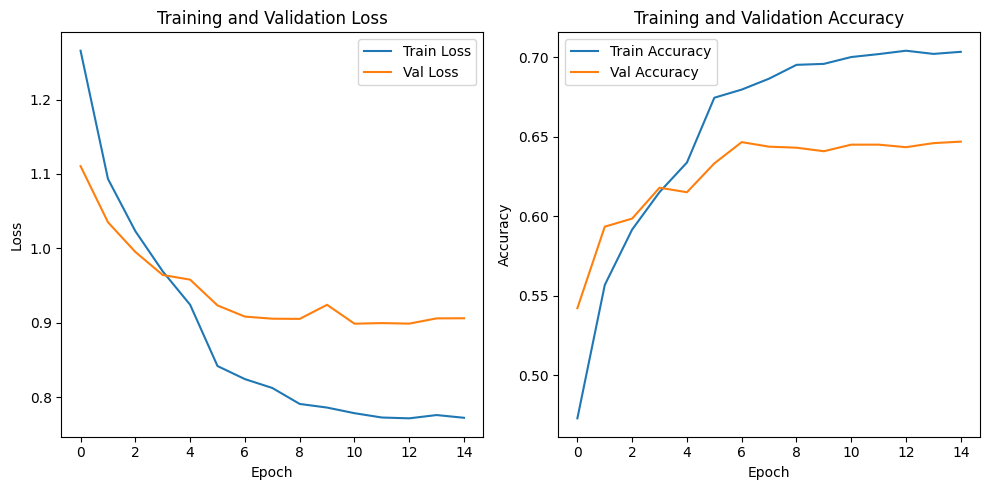

In [ ]:
plot_training_history(train_loss_history, val_loss_history, train_acc_history, val_acc_history)

eval

Test Accuracy: 0.6430


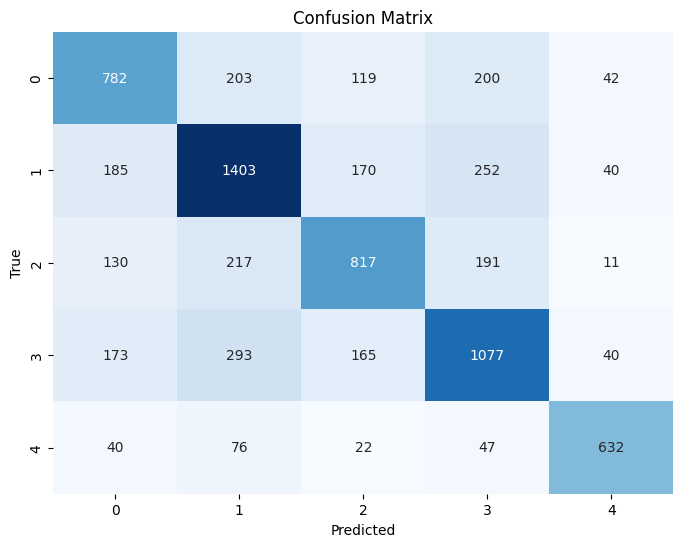

In [ ]:
from sklearn.metrics import accuracy_score, confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

model_ft.eval()

predictions = []
true_labels = []

# Iterate over test loader
for inputs, labels in test_loader:
    inputs = inputs.to(device)
    labels = labels.to(device)

    # Forward pass
    outputs = model_ft(inputs)
    _, preds = torch.max(outputs, 1)

    # Append predictions and true labels
    predictions.extend(preds.cpu().numpy())
    true_labels.extend(labels.cpu().numpy())

# Calculate accuracy
accuracy = accuracy_score(true_labels, predictions)
print(f'Test Accuracy: {accuracy:.4f}')

# Create confusion matrix
cm = confusion_matrix(true_labels, predictions)
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', cbar=False)
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix')
plt.show()